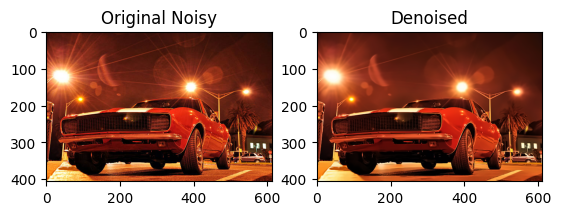

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the noisy image
img = cv2.imread('img2.jpg')
dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

# Show the results
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Noisy')
plt.subplot(122), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)), plt.title('Denoised')
plt.show()


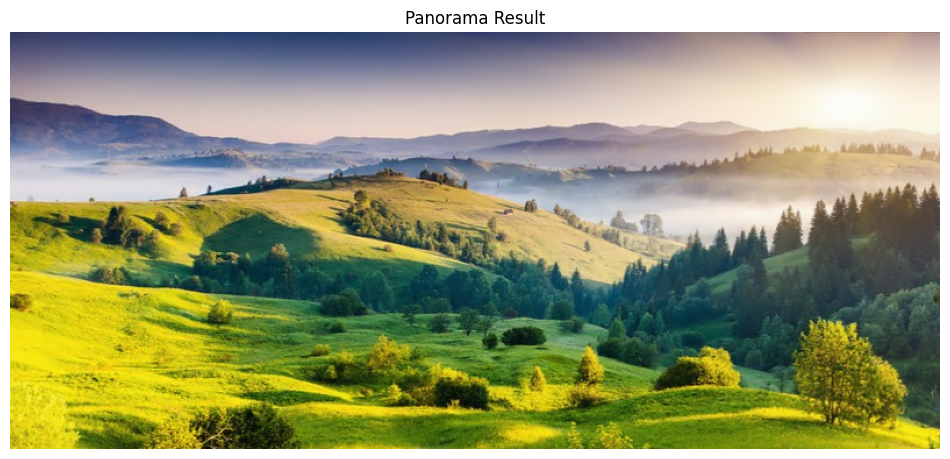

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load images
imgs = [cv2.imread('img4.jpg'), cv2.imread('img5.jpg')]

# Create stitcher and stitch
stitcher = cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(imgs)

if status == cv2.Stitcher_OK:
    cv2.imwrite("panorama.jpg", stitched)

    # Convert BGR to RGB for matplotlib
    stitched_rgb = cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(12, 6))
    plt.imshow(stitched_rgb)
    plt.title("Panorama Result")
    plt.axis('off')
    plt.show()

else:
    print("Stitching failed :(")


Rotation Matrix R:
 [[ 9.99882701e-01 -1.53160055e-02 -6.32268862e-05]
 [ 1.53160054e-02  9.99882703e-01 -2.05411069e-06]
 [ 6.32509307e-05  1.08548642e-06  9.99999998e-01]]
Translation Vector t:
 [[-9.99742640e-01]
 [-2.26857966e-02]
 [-9.59922035e-05]]


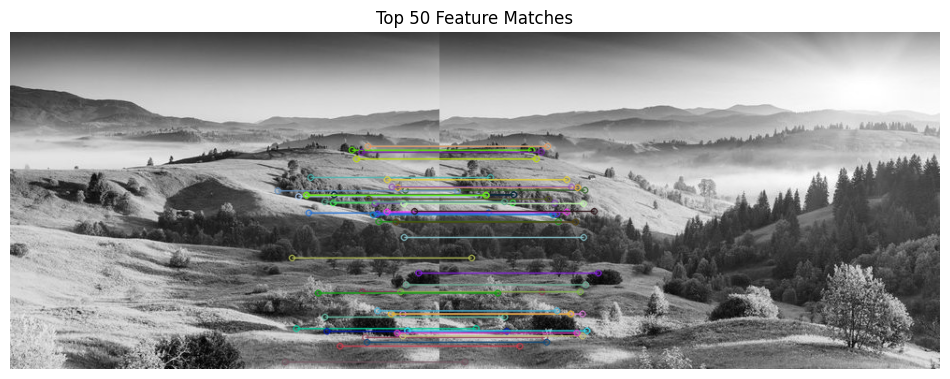

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('img4.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('img5.jpg', cv2.IMREAD_GRAYSCALE)

# Create SIFT detector
sift = cv2.SIFT_create()

# Detect and compute keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create Brute-Force Matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in order of distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# Compute Essential matrix
E, mask = cv2.findEssentialMat(pts1, pts2, focal=1.0, pp=(0., 0.), method=cv2.RANSAC, prob=0.999)

# Recover relative camera rotation and translation
_, R, t, mask = cv2.recoverPose(E, pts1, pts2)

# Print result
print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)

# Optional: Draw top 50 matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

# Show match visualization
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title("Top 50 Feature Matches")
plt.axis('off')
plt.show()


task2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Load data
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize to [0,1] and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def add_noise(imgs):
    noise_factor = 0.5
    noisy = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)


In [ ]:
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 212ms/step - loss: 0.1216 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 204ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 200ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 204ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 204ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 204ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 204ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 203ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 200ms/step - loss: 0.1118 - val_loss: 0.1140


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


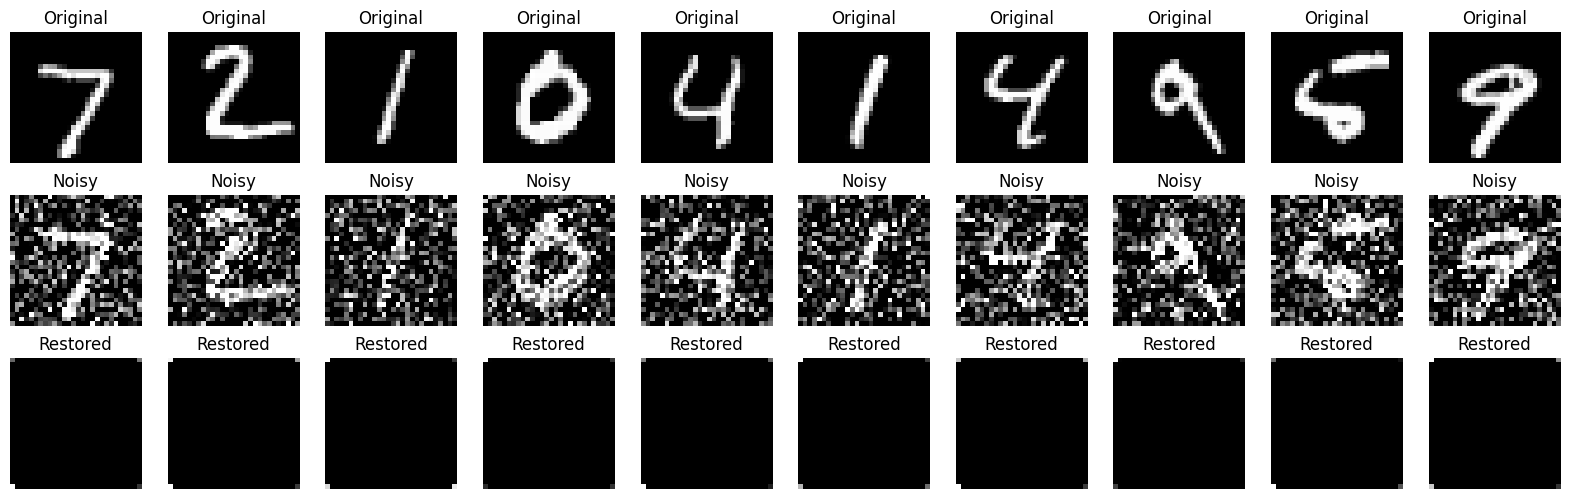

In [ ]:
# Predict restored images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Plot original, noisy, and restored
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # Denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Restored")
    plt.axis("off")

plt.show()


In [ ]:
import math

def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print("Sample PSNR:", psnr(x_test[0], decoded_imgs[0]))


Sample PSNR: 11.22223631998491
